# Modules

In [1]:
import pandas as pd
import numpy as np
import random
import math

import matplotlib.pyplot as plt
%matplotlib inline

from pprint import pprint


In [2]:
#load data into panda data frame
df = pd.read_csv("mydata.txt") 

# 80/20 spliting of data

In [3]:
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df


In [4]:
random.seed(0)
train_df, test_df = train_test_split(df, test_size=0.2)

# Determing the type of feature

In [5]:
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

# Tree based on information gain 

In [6]:
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

In [7]:
feature_types = determine_type_of_feature(df)
i=0
for column in df.columns:
    print(column, "-",feature_types[i])
    i = i + 1
    

intercolumnardistance - continuous
uppermargin - continuous
lowermargin - continuous
exploitation - continuous
rownumber - continuous
modularratio - continuous
interlinearspacing - continuous
weight - continuous
peaknumber - continuous
ratio - continuous
lable - categorical


In [8]:
def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

In [9]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

In [10]:
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [11]:
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [12]:
def get_potential_splits(data):
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):          # excluding the last column which is the label
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        type_of_feature = FEATURE_TYPES[column_index]
        if type_of_feature == "continuous":
            potential_splits[column_index] = []
            for index in range(len(unique_values)):
                if index != 0:
                    current_value = unique_values[index]
                    previous_value = unique_values[index - 1]
                    potential_split = (current_value + previous_value) / 2

                    potential_splits[column_index].append(potential_split)
        
        # feature is categorical
        # (there need to be at least 2 unique values, otherwise in the
        # split_data function data_below would contain all data points
        # and data_above would be empty)
        elif len(unique_values) > 1:
            potential_splits[column_index] = unique_values
    
    return potential_splits

Best split based on the information gain

In [13]:
def determine_best_split(data, potential_splits):
    
    #overall_entropy = 9999
    information_gain = -999
    entropy_parent = 0
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)
            #calculation_of_information_gain
            current_information_gain= entropy_parent - current_overall_entropy

            if current_information_gain > information_gain:
                information_gain = current_information_gain
                best_split_column = column_index
                best_split_value = value
                entropy_parent=current_overall_entropy
    
    return best_split_column, best_split_value,

In [14]:
def decision_tree_algorithm(df, max_depth, counter=0, min_samples=2):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

        # potential split functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
       
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion) based on decision
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
        
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [15]:
information_gain_tree = decision_tree_algorithm(df,10)

In [16]:
pprint(information_gain_tree)

{'rownumber <= 0.306407': [{'intercolumnardistance <= -0.19682': [{'intercolumnardistance <= -1.5484715': [{'intercolumnardistance <= -2.6902775': [{'interlinearspacing <= -0.3272045': [{'interlinearspacing <= -2.101474': ['A',
                                                                                                                                                                                                                               {'uppermargin <= 0.5095815': ['I',
                                                                                                                                                                                                                                                             'Y']}]},
                                                                                                                                                                                          {'exploitation <= 1.0325280000000001': [{'lowermargin <= 0.2391829

                                                                                                                                                        {'ratio <= 0.1435595': ['Y',
                                                                                                                                                                                'X']}]},
                                                                                                                           'I']}]},
                                                      'I']}]}


#  predicting the test_data

In [17]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

   
    if comparison_operator == "<=":  # feature is continuous
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical then exicute this part 
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part of tree
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [18]:
example=test_df.iloc[5]
example

intercolumnardistance   -0.079554
uppermargin              0.187683
lowermargin             -0.070224
exploitation             0.211236
rownumber                0.261718
modularratio              1.35301
interlinearspacing      -0.044076
weight                  -0.797392
peaknumber               0.095265
ratio                    1.405159
lable                           A
Name: 1658, dtype: object

In [19]:
sample_data=test_df.iloc[5]
test_data = pd.Series(sample_data)
prediction = classify_example(test_data,information_gain_tree)
prediction

'A'

In [20]:
def calculate_accuracy(df, tree):#accuracy function

    df["classification"] = df.apply(classify_example, axis=1, args=(tree,))
    df["classification_correct"] = df["classification"] == df["lable"]
    
    accuracy = df["classification_correct"].mean()
    
    return accuracy

# Final accuracy calculation

In [21]:
#tree using information gain measure  

test_df, train_df = train_test_split(df, 0.2)
tree = decision_tree_algorithm(train_df, max_depth=10)
accuracy = calculate_accuracy(test_df, tree)
accuracy

0.5788834951456311

# QUEATION_2

In [22]:
#calculating the accuracy of 10 different random samples
accList=list()
bestTree={}
a=-math.inf
for i in range(10):
    testData,trainData=train_test_split(df,test_size=0.2)
    tree = decision_tree_algorithm(trainData,10)
    acc= calculate_accuracy(testData,tree)
    if(a<acc):
        a=acc
        bestTree=tree
    accList.append(acc)
    


In [23]:
print("Accuracy of tree on ten different Random Data using information gain as measure-\n")
for i in accList:
    print(i)
    print()
print("Best Accurracy-",a)

Accuracy of tree on ten different Random Data using information gain as measure-

0.6043689320388349

0.6110436893203883

0.6322815533980582

0.6547330097087378

0.6365291262135923

0.6110436893203883

0.6140776699029126

0.5807038834951457

0.5849514563106796

0.6116504854368932

Best Accurracy- 0.6547330097087378


In [24]:
#best_tree for acording to the accuracy of data 
pprint(bestTree)

{'rownumber <= 0.306407': [{'intercolumnardistance <= -0.135101': [{'intercolumnardistance <= -0.560964': [{'intercolumnardistance <= -1.4558925': ['A',
                                                                                                                                                    'Y']},
                                                                                                           {'exploitation <= 1.057264': [{'lowermargin <= 0.310311': [{'exploitation <= -0.10292899999999999': [{'intercolumnardistance <= -0.369634': ['C',
                                                                                                                                                                                                                                                        'E']},
                                                                                                                                                                                        

# QUESTION_3

In [25]:
#finding accuracy on diffrent depths of the tree
def get_accuracy(new_test_data):
    test_accuracies = []
    depth = [3,4,5,7,8,9,12,15,20,25] 
    for i in range( len(depth) ):
        tree = decision_tree_algorithm(train_df, max_depth=depth[i])
        accuracy = calculate_accuracy(new_test_data, tree)
        test_accuracies.append(accuracy)
    return test_accuracies

In [26]:
test_accuracies=get_accuracy(test_df)

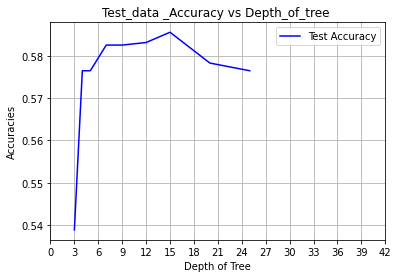

In [27]:
X_N = [3,4,5,7,8,9,12,15,20,25]
plt.plot(X_N,test_accuracies, 'b', label='Test Accuracy')
plt.title('Test_data _Accuracy vs Depth_of_tree ')
plt.ylabel('Accuracies')
plt.xlabel('Depth of Tree')
plt.legend()
plt.grid()
plt.xticks(np.arange(0,45, step=3))
plt.show()

# QUESTION_5


In [28]:
# best tree is formed at depth of 15 
best_tree= decision_tree_algorithm(train_df,15)

In [29]:
pprint(best_tree)

{'rownumber <= 0.395785': [{'intercolumnardistance <= -0.19682': [{'peaknumber <= 0.40708049999999996': [{'intercolumnardistance <= -2.548323': [{'intercolumnardistance <= -2.8137160000000003': [{'uppermargin <= 0.678382': [{'exploitation <= 1.0325280000000001': ['A',
                                                                                                                                                                                                                                                                        'X']},
                                                                                                                                                                                                                                'Y']},
                                                                                                                                                                                                   'H']},
                           